In [ ]:
# default_exp forecast

# forecast

> Forecast para deteccao **anomalias em series temporais**.
    - HoltWinters
    - ARIMA
    - Prophet

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();
sns.set_style("whitegrid")

In [ ]:
#export
import numpy as np
import pandas as pd

# Auto-Arima
import pmdarima as pm
# Holt-Winters
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# Prophet
from fbprophet import Prophet

## Auto Arima

In [ ]:
#export
def anomaly_arima(ts, train_split=0.4, d=None,
                       seasonal=False, seasonal_periods=7,
                       only_lower=False):
    '''
    Utiliza Auro-Arima para detectar anomalias.
    
    Input:
        Serie Temporal
        ts: Serie Temporal pd.Series() com DateTimeIndex

        Parametros de Treino
        train_split: % Porcentagem do conjunto de dados inicial usado para treinar o modelo.

        Parametros do ARIMA
        d: Número minimo de diferenciações
        seasonal: Se True o ARIMA irá modelar a sazonalidade
        seasonal_periods: Inteiro indicando o periodo da serie temporal
    
    Output:
        pd.Series com os valores de anomalia 
    '''
    # checks
    if len(ts) == 0:
        raise ValueError('Time Series is Empty')
        
    if not isinstance(ts, pd.core.series.Series):
        raise ValueError('ts is not a pd.Series')
        
    if not isinstance(ts.index, pd.core.indexes.datetimes.DatetimeIndex):
        raise ValueError('ts.index is not a DatetimeIndex')
        
    if train_split < 0 or train_split > 1:
        raise ValueError('train_split out of range, should be [0, 1]')
    
    # Initial Train Set
    start = ts.index[int(train_split*len(ts.index))]
    
    # Auto-Arima
    model = pm.auto_arima(ts[:start], seasonal=seasonal, d=d,
                          m=seasonal_periods, suppress_warnings=True)
 
    y_pred = []
    conf_int = []
    for y in ts[start:]:
        # predict
        y_p, y_int = model.predict(1, return_conf_int=True)
        # update
        model.update(y, suppress_warnings=True)
        # save values
        y_pred.append(y)
        conf_int.append(y_int)
        
    # search anomalies
    y_pred = np.array(y_pred)
    conf_int = np.array(conf_int).reshape(-1, 2)
    
    normal = check_int(y_pred, conf_int, only_lower)
    anomalies = ts[start:][~normal]

    return anomalies

In [ ]:
#export
def check_int(y, conf_interval, only_lower=False):
    '''
    Check if y is inside the conf_interval
    Input:
        y: Numpy Array 1D
        conf_int: Numpy Array 2D with (-1, 2) Shape
                  [[9.0, 15.0],
                   [4.5,  8.7],
                   [..     ..],
                   [10.4,  13.2]]
    '''
    lower = y > conf_interval[:, 0]
    upper = y < conf_interval[:, 1]
    
    if only_lower:
        return lower
    else:
        return np.bitwise_and(lower, upper)

## Using anomaly_iter_arima

In [ ]:
df1 = pd.read_csv('./dados/daily-min-temperatures.csv')

df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date', inplace=True)
df1.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


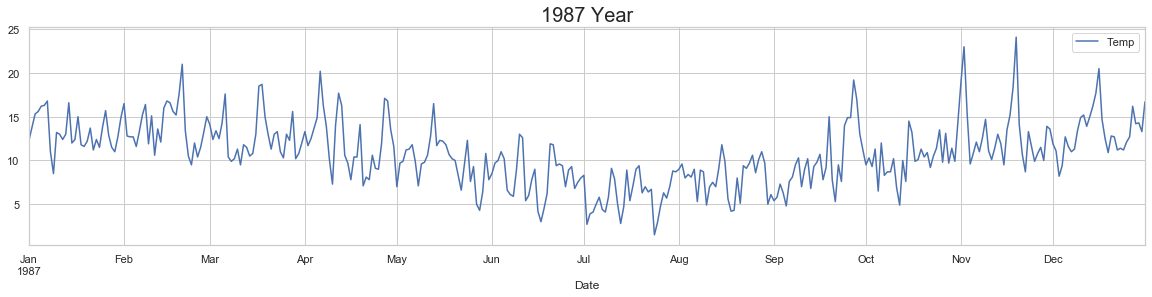

In [ ]:
df1['1987'].plot(figsize=(20, 4))
plt.title("1987 Year", fontsize=20);

**Train Model**

In [ ]:
# fit model
ts = df1['1987']['Temp']

anomalies = anomaly_iter_arima(ts, d=1)
anomalies.head()

/home/demenezes/.local/lib/python3.8/site-packages/pmdarima/arima/_validation.py:60: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(3,1,1)(0,0,0)[0]          


Date
1987-06-12     5.4
1987-06-16     4.2
1987-07-02     2.7
1987-07-24     1.5
1987-09-19    15.0
Name: Temp, dtype: float64

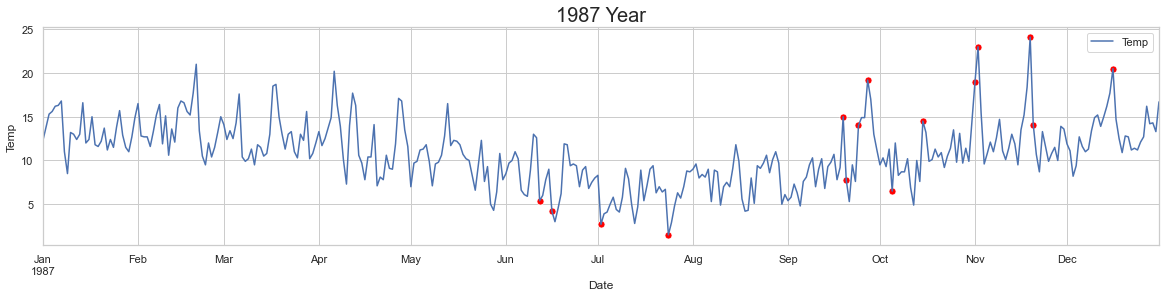

In [ ]:
df1['1987'].plot(figsize=(20, 4))
sns.scatterplot(x=anomalies.index, y=anomalies, s=50, color='red')
plt.title("1987 Year", fontsize=20);

### Holt-Winters

In [ ]:
ts = df1['Temp']

In [ ]:
#export

def anomaly_holtwinters(ts, seasonal=None, seasonal_periods=7):
    '''
    Input:
        # Serie Temporal
        ts: Serie Temporal pd.Series() com DateTimeIndex
        
        # Parametros do algoritmo
        seasonal: 'add', 'mul', None
        seasonal_periods: Inteiro indicando o periodo da serie temporal
    '''
    model = ExponentialSmoothing(ts, seasonal=seasonal, 
                                 seasonal_periods=seasonal_periods)
    res = model.fit(ts)
    

In [ ]:
model = ExponentialSmoothing(ts)
model.fit(ts)

/home/demenezes/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


TypeError: smoothing_level must be float_like (float or np.inexact) or None

In [ ]:
ExponentialSmoothing??